In [67]:
GC.gc()

include("src/utils.jl")
include("src/solver.jl")
include("src/loader.jl");

In [68]:
filename = "profiles.csv"
YEARS = [2014, 2015, 2016, 2017, 2018]
if ! @isdefined(time_profiles) || issubset(YEARS, keys(time_profiles)) == false
    time_profiles, wind_profiles, solar_profiles = load_profiles(filename, YEARS, true)
end;

print("Loaded profiles for years: ", keys(time_profiles), "\n")

Loaded profiles for years: Any[2018, 2014, 2017, 2016, 2015]


In [69]:
# Default values
DEMAND = 1000. # Kg of H2
# Battery parameters
EBAT = 0.9 # per month discharge
FBAT = 100. # MW
COST_BAT = 250000 * 0.0002 # € / MWh
# Electrolyzer parameters
EELEC = 0.050 # MWh / Kg
COST_ELEC =  1200000 * 0.0004 # € / MW
CAPA_ELEC_UPPER = 1000 # MW
# Tank parameters
COST_TANK = 407. # € / Kg
# Grid parameters
PRICE_GRID = 1000. # € / MWh
PRICE_CURTAILING = 750. # € / MWh;
PRICE_PENALITY = 0 # € / times changed
PRICE_PROD_CHANGE = 1 # € / kg of change in production level
# Renewable pricing, from https://atb.nrel.gov/electricity/2022/index
# For now : 20 year lifespan, no discount rate + O&M cost per year
COST_WIND = 1352 * 1000 / 20 + 43 * 1000 # € / MW
COST_SOLAR = 1233 * 1000 / 20 + 23 * 1000 # € / MW
# Upper bound on the battery capacity
CAPA_BAT_UPPER = 3 * DEMAND * EELEC ;# MW

In [70]:
D = 1000.
# Aggregate the 5 years of profiles into a single profile
full_wind_profile :: Vector{Float64} = []
full_solar_profile :: Vector{Float64} = []
full_time_profile :: Vector{DateTime} = []

for year in sort!(collect(keys(wind_profiles)))
    print("Loading year $year \n")
    append!(full_time_profile, time_profiles[year])
    append!(full_wind_profile, wind_profiles[year])
    append!(full_solar_profile, solar_profiles[year])
end

print("Wind profile is of length $(length(full_wind_profile)) \n")
print("Solar profile is of length $(length(full_solar_profile)) \n")
print("5 * 24 * 365 + 24 is $(5 * 24 * 365 + 24) \n")

Loading year 2014 
Loading year 2015 
Loading year 2016 
Loading year 2017 
Loading year 2018 
Wind profile is of length 43824 
Solar profile is of length 43824 
5 * 24 * 365 + 24 is 43824 


In [71]:
# We need to update the annualized cost for the permanent installations
n_years = length(keys(wind_profiles))
cost_elec_n = COST_ELEC * n_years
cost_bat_n = COST_BAT * n_years
cost_tank_n = COST_TANK * n_years
cost_wind_n = COST_WIND * n_years
cost_solar_n = COST_SOLAR * n_years

output4 = solve(
    full_wind_profile, full_solar_profile, # WIND_PROFILE, SOLAR_PROFILE
    DEMAND, # DEMAND
    missing, missing, # WIND_CAPA, SOLAR_CAPA, if set to missing, the solver will optimize the capacities
    missing, missing, missing, # BAT_SIZE, TANK_SIZE, ELEC_CAPA, if set to missing, the solver will optimize the capacities
    PRICE_GRID, PRICE_CURTAILING, # PRICE_GRID, PRICE_CURTAILING
    PRICE_PENALITY, PRICE_PROD_CHANGE, #PRICE_PENALITY, PRICE_PROD_CHANGE
    CAPA_BAT_UPPER, CAPA_ELEC_UPPER, # CAPA_BAT_UPPER, CAPA_ELEC_UPPER
    EBAT, FBAT, EELEC, # EBAT, FBAT, EELEC
    cost_elec_n, cost_bat_n, cost_tank_n, # COST_ELEC, COST_BAT, COST_TANK
    cost_wind_n , cost_solar_n, # COST_WIND, COST_SOLAR
    0., # No initial charge
    0., # No initial stock
    missing, # No final charge constraint
    missing, # No final stock constraint
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ... 


Adding constraints ... 


Optimizing ...


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 482070 rows, 438250 columns and 1426744 nonzeros
Model fingerprint: 0xb2ca6e61
Coefficient statistics:
  Matrix range     [1e-04, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+03]
  RHS range        [1e+03, 1e+03]
Presolve removed 175305 rows and 131480 columns
Presolve time: 3.41s
Presolved: 91636 rows, 350590 columns, 1255404 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Free vars  : 3981
 AA' NZ     : 7.159e+05
 Factor NZ  : 1.466e+06 (roughly 200 MB of memory)
 Factor Ops : 2.488e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal  

In [72]:
# Print the solution properties
print_solution_propreties(output4, full_time_profile, full_wind_profile, full_solar_profile)

Battery capacity: 150 MWh, Tank capacity: 55744 kg, Electrolyser capacity: 2700.0 kg/h
Wind capacity: 132 MW, Solar capacity: 195 MW 

Wind proportion in capacity: 0.4036697247706422 
Wind proportion in generation: 0.5746934833719586 

Total electricity needed: 2.1912e6 MWh, Total electricity produced: 2.063756e6 MWh
Total electricity imported: 225042.0 MWh, Total electricity curtailment: 97210.0 MWh 

Produced / Needed ratio : 0.941838262139467 

Storage cost: 1.1347691154258096e8, operating cost: 2.99422318639577e8
Electrolyser cost : 325391.020008631, electricity plant cost: 1.5608579457966876e8
Total cost: 5.693104157818353e8


In [73]:
# Get the plots
prod4, cons4, bat4, tank4 = plot_solution(output4, full_time_profile);

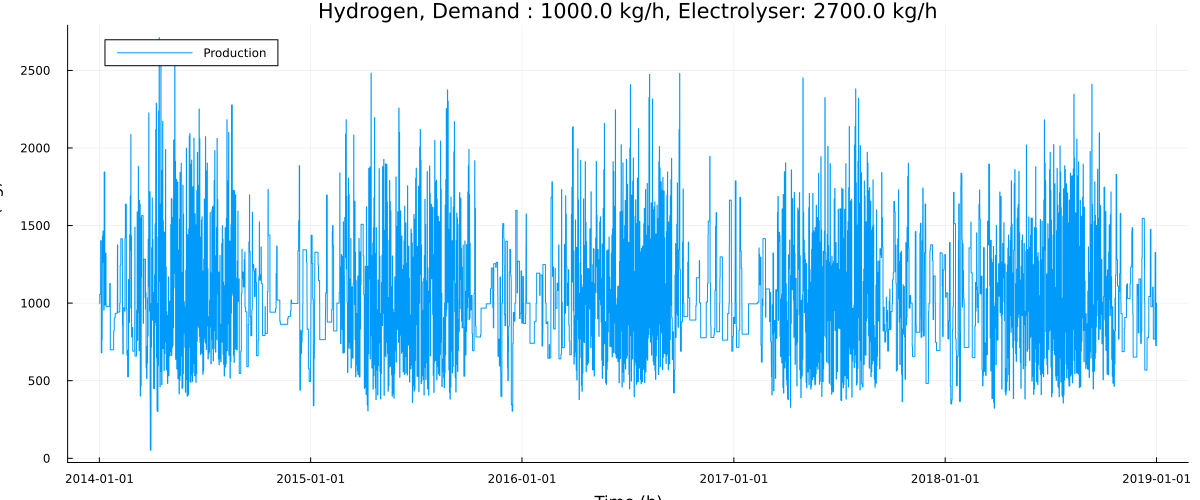

In [74]:
prod4

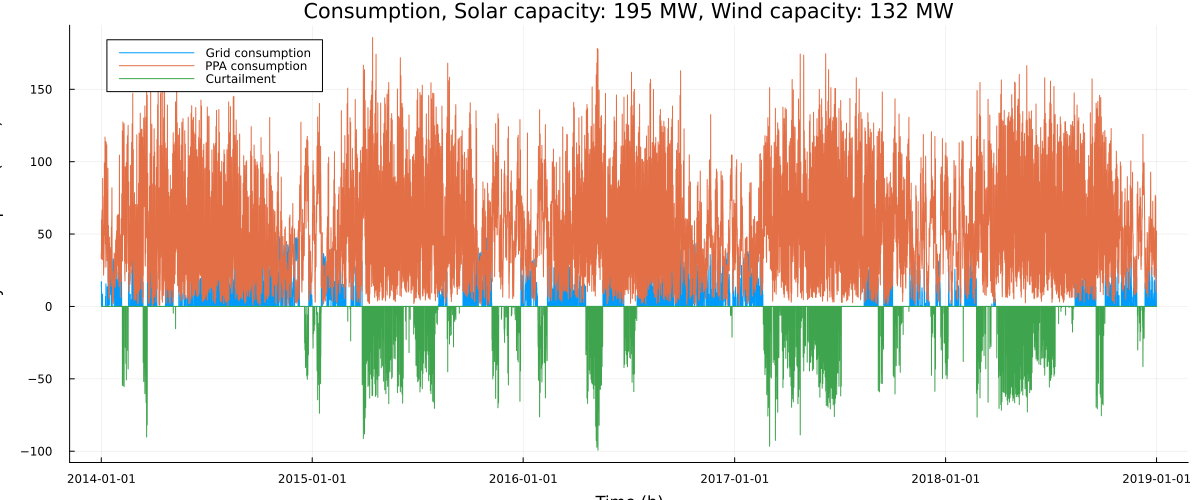

In [75]:
cons4

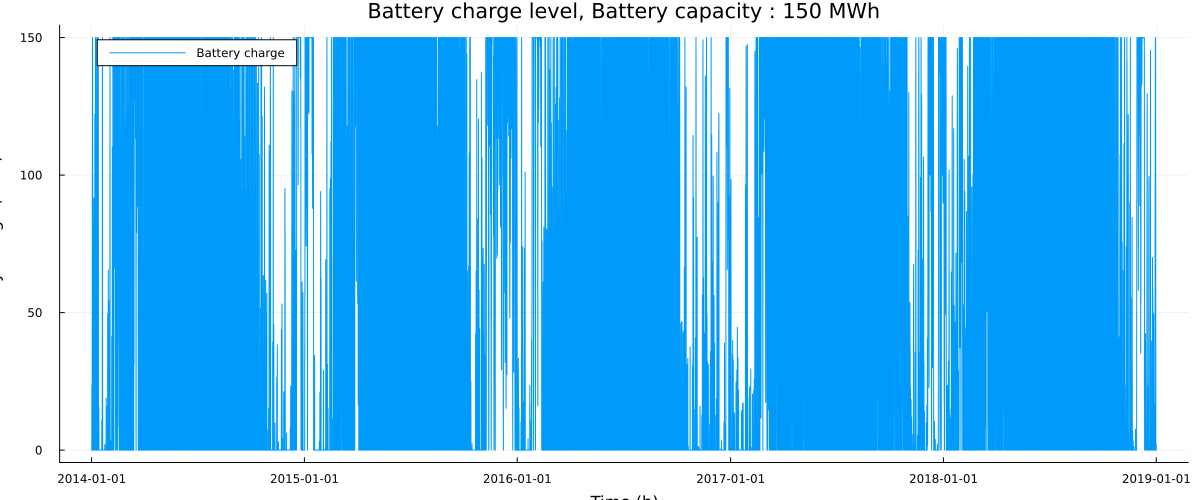

In [76]:
bat4

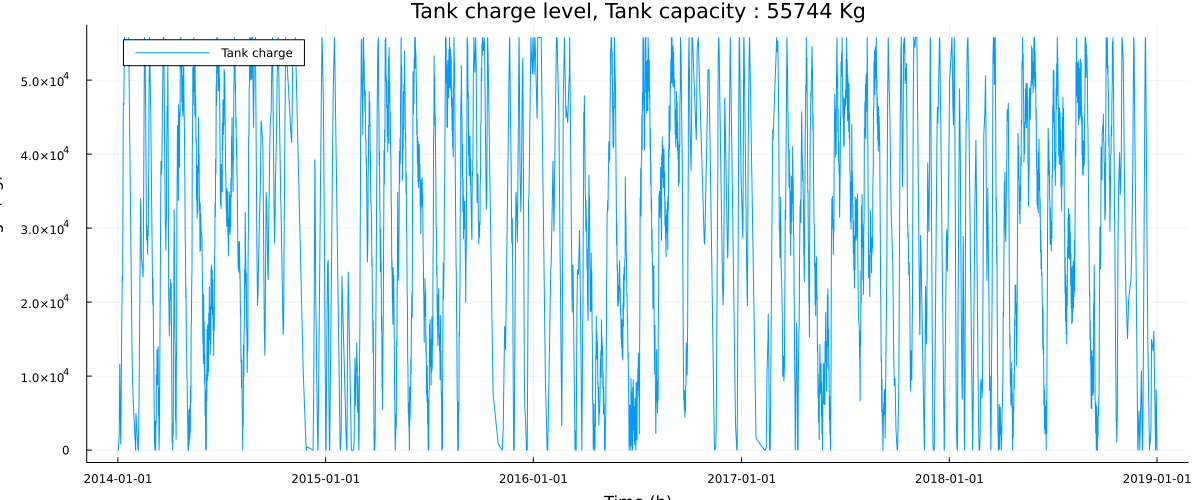

In [77]:
tank4